In [145]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(42)
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=UserWarning)

In [146]:
path = 'input/tradeTimeInfo.csv'

In [147]:
df = pd.read_csv(path).drop(columns='Unnamed: 0')
df.T

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
carid,68603.000000,12312.000000,57655.000000,45688.000000,52081.000000,6729.000000,766.000000,10453.000000,65800.000000,36776.000000,...,63059.000000,63469.000000,45307.000000,57147.000000,17286.000000,10177.000000,54312.000000,45597.000000,38629.000000,58619.000000
pushPrice,3.980000,4.500000,23.900000,20.579800,12.280000,18.500000,9.800000,10.800000,12.280000,16.800000,...,2.000000,11.800000,9.900000,11.380000,16.800000,22.880000,12.300000,15.380000,36.880000,39.380000
isTraded,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
predPrice,4.571188,5.326470,24.260490,26.192541,12.397629,16.249944,9.782567,11.366560,11.435832,17.419523,...,2.048355,12.571402,9.504020,11.201090,16.234233,21.471404,12.486524,15.236936,36.064669,35.530893
isCut,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
cutNum,0.000000,0.000000,1.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,2.000000
cutPrice1,3.980000,4.500000,23.000000,20.579800,11.900000,17.680000,9.800000,10.800000,12.280000,16.800000,...,2.000000,11.800000,9.900000,11.380000,16.400000,22.880000,12.300000,15.380000,36.600000,38.600000
cutPrice2,3.980000,4.500000,23.000000,20.579800,11.900000,17.879900,9.800000,10.800000,12.280000,16.800000,...,2.000000,11.800000,9.900000,11.380000,15.900000,22.880000,12.300000,15.380000,36.600000,38.000000
cutPrice3,3.980000,4.500000,23.000000,20.579800,11.900000,16.879900,9.800000,10.800000,12.280000,16.800000,...,2.000000,11.800000,9.900000,11.380000,15.700000,22.880000,12.300000,15.380000,36.600000,38.000000
dFirstCutTime,0.000000,0.000000,23.000000,0.000000,21.000000,27.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,5.000000,2.000000


In [148]:
df = df[df['pTruePrice'] <= 0.5]

In [149]:
df = df[df['isTraded'] == 1]

In [150]:
df.drop(columns='isTraded', inplace=True)

In [151]:
influ_features = ['pTruePrice', 'dCutPrice', 'dTruePrice', 'cutNum',
        'pFristCutPrice', 'pCutPrice', 'isCut', 'dFirstCutPrice',
        'pSecondCutPrice', 'dSecondCutPrice', 'pushPrice', 'cutPrice1',
        'pThirdCutPrice', 'cutPrice2', 'cutPrice3', 'predPrice',
        'dThirdCutPrice']

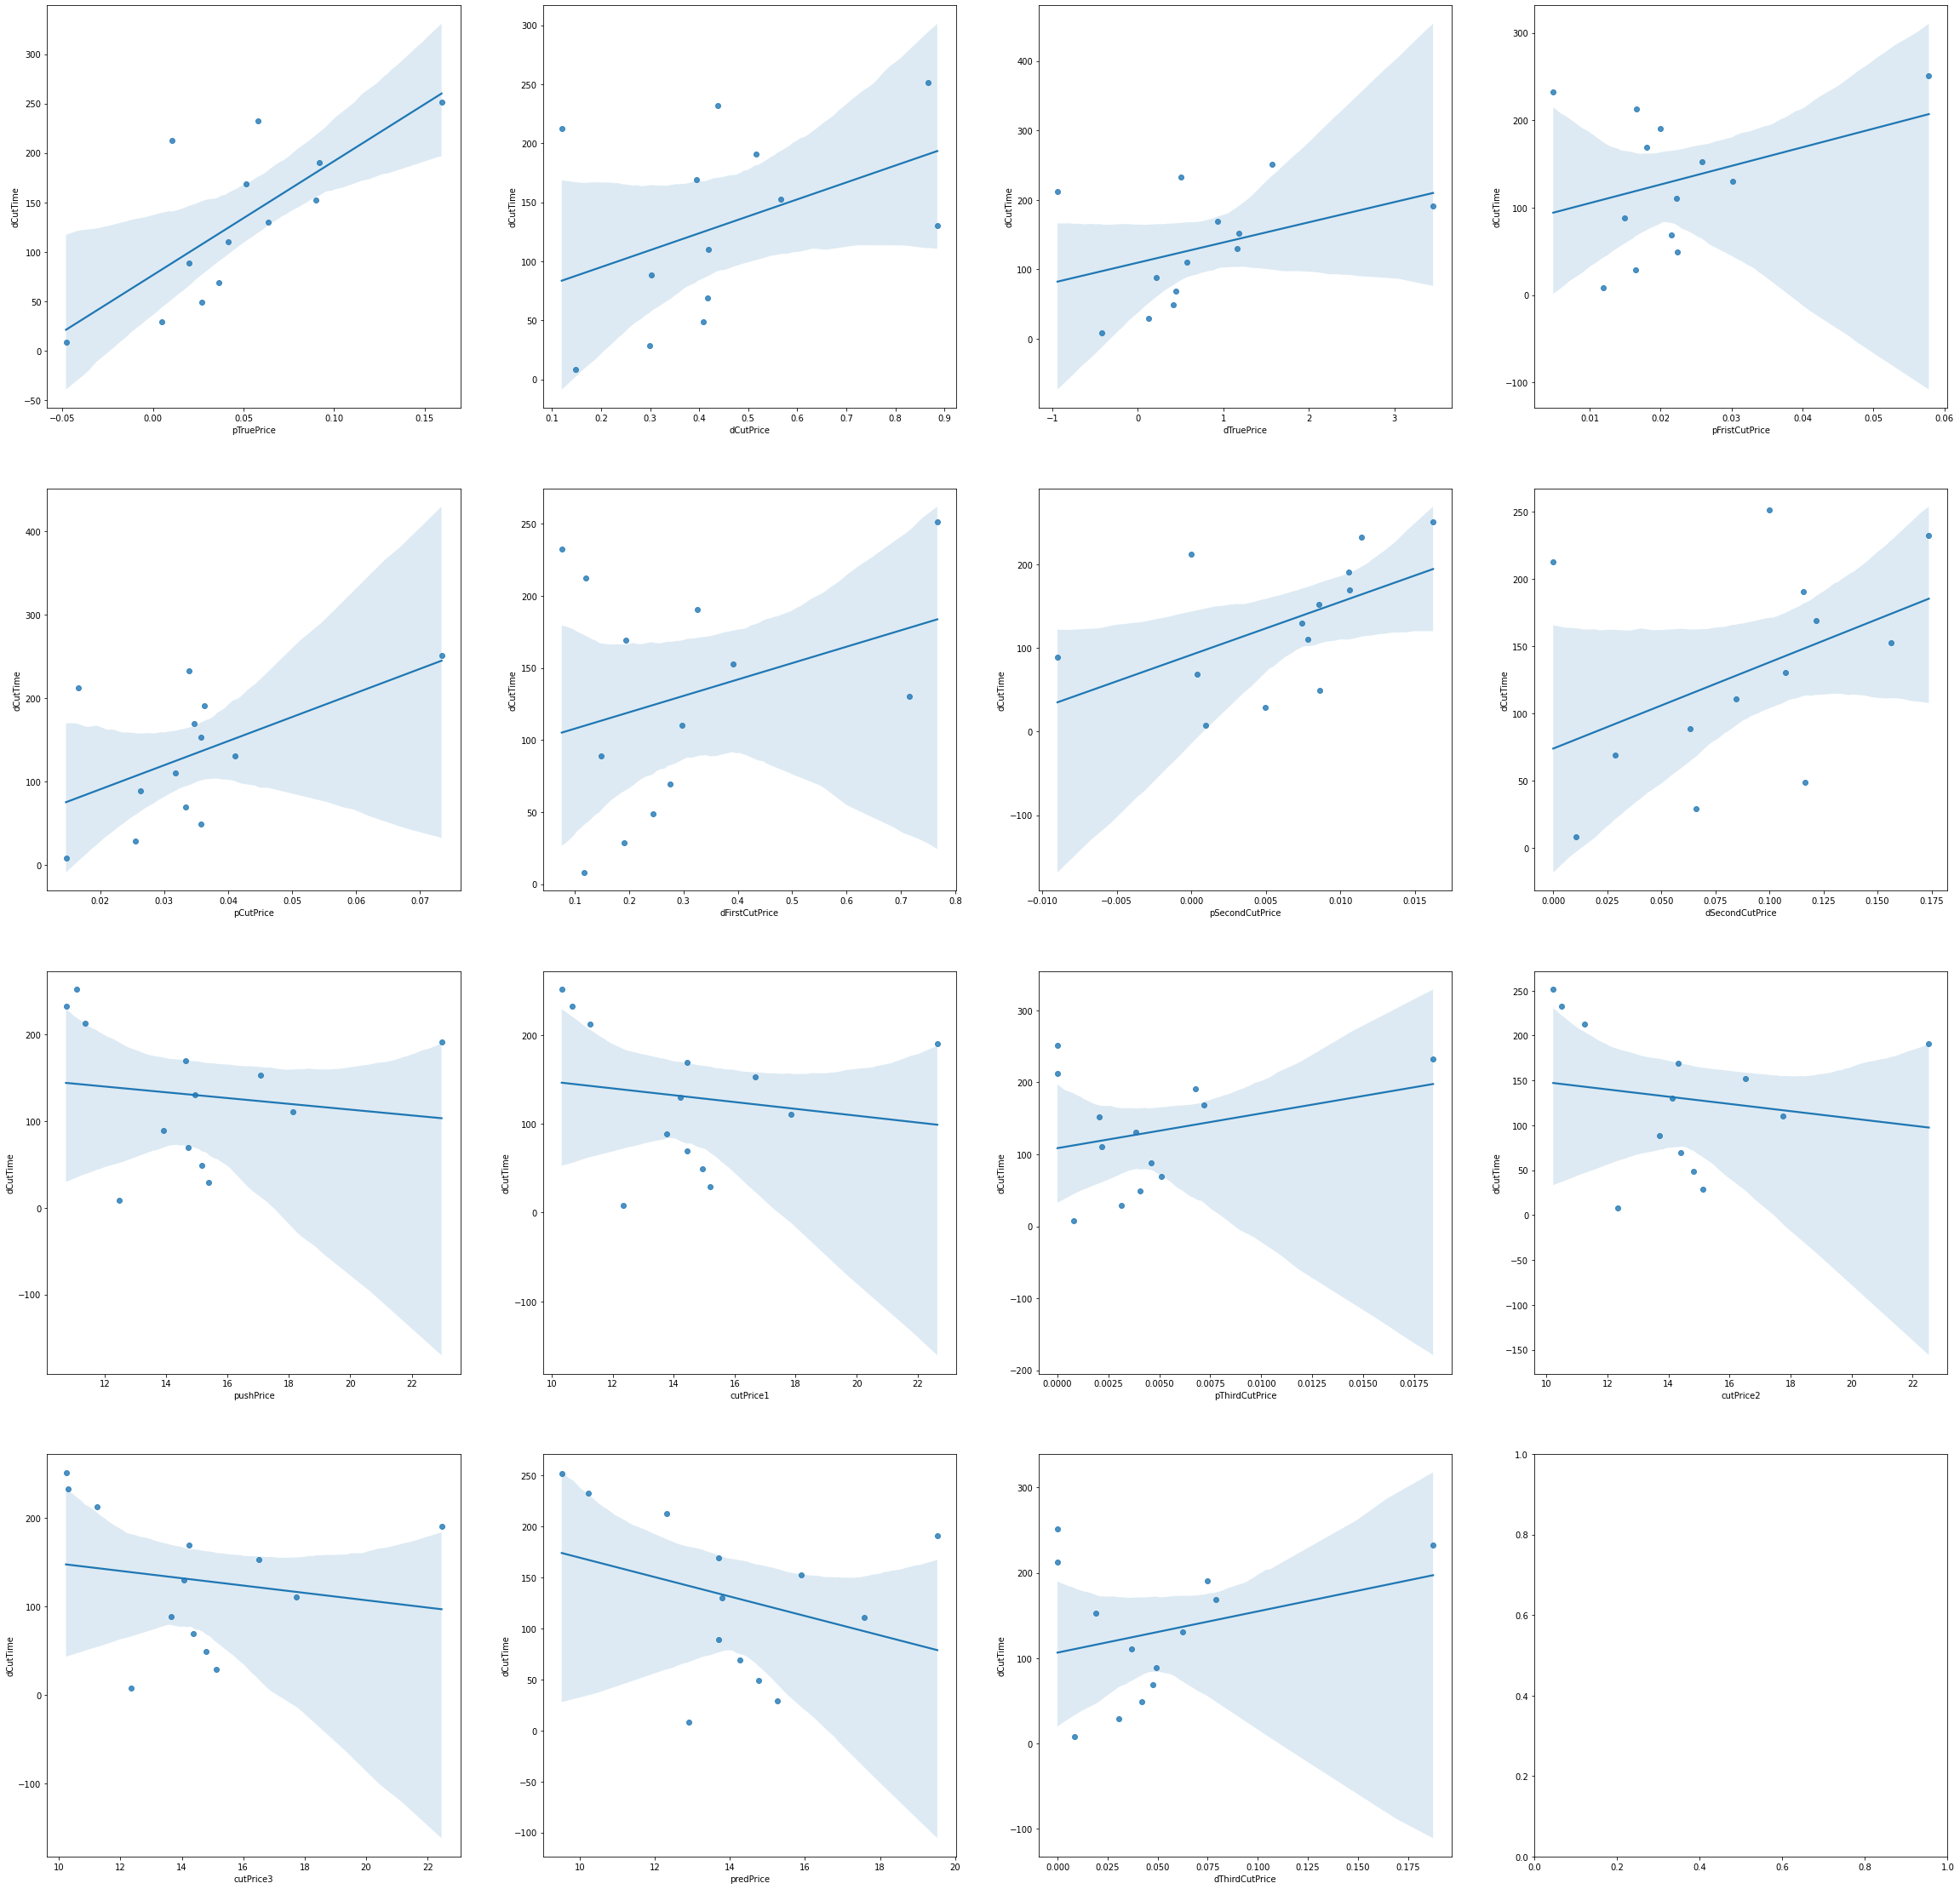

In [152]:
contin_feature = influ_features[:]
contin_feature.remove('cutNum')
contin_feature.remove('isCut')

num_bins = int(np.floor(1 + np.log2(len(df))))
fig, ax_arr = plt.subplots(4, 4, figsize=(40, 40))

for i, feature in enumerate(contin_feature):
    feature_df = df[[feature, 'dCutTime']]
    feature_df['bins'] = pd.cut(df['dCutTime'], bins=num_bins, labels=False)
    result_df = feature_df.groupby('bins').mean().sort_values(by=feature, ignore_index=True)
    sns.regplot(x = feature, y = 'dCutTime', data=result_df, ax = ax_arr[i // 4][i % 4])

In [153]:
train_df = pd.read_csv('input/inputTrain.csv').drop(columns=['Unnamed: 0', 'price'])
train_df

,carid,tradeTime,mileage,color_1,color_2,color_3,color_4,color_5,color_6,color_7,...,cityId7,l1,l2,l3,l4,l5,l6,l7,l8,l9
0,1,0.840336,-0.534415,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.230769,-1.080000,0.668317,-1.230769,-1.080000,0.668317,-1.175993,-0.247441,0.229515
1,2,0.827731,0.315772,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-0.062678,-0.613333,-0.049505,-0.062678,-0.613333,-0.049505,-0.271037,-0.252904,-0.226296
2,5,0.802521,1.028558,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-0.390313,-1.280000,-0.222772,-0.390313,-1.280000,-0.222772,-0.715401,-0.604505,-0.531781
3,6,0.844538,-0.089701,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.433048,0.173333,1.074257,-0.433048,0.173333,1.074257,-0.235116,0.635244,0.918661
4,7,0.848739,-0.154414,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.960114,-0.506667,0.574257,-0.960114,-0.506667,0.574257,-0.813323,-0.169895,0.311352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29994,18531,0.701681,0.538139,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-1.017094,-1.546667,0.396040,-1.017094,-1.546667,0.396040,-1.196486,-0.369935,-0.112968
29995,4294,-0.798319,0.680581,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.877493,0.320000,-0.049505,0.877493,0.320000,-0.049505,0.693357,0.270279,0.009225
29996,20584,-0.310924,0.478198,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.037037,-1.613333,0.099010,0.037037,-1.613333,0.099010,-0.568485,-0.047498,-0.362698
29997,11490,-0.130252,0.441610,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.749288,-0.013333,-0.198020,0.749288,-0.013333,-0.198020,0.480517,0.040985,-0.199016


In [154]:
df = pd.merge(df, train_df, on='carid')
df

,carid,pushPrice,predPrice,isCut,cutNum,cutPrice1,cutPrice2,cutPrice3,dFirstCutTime,dSecondCutTime,...,cityId7,l1,l2,l3,l4,l5,l6,l7,l8,l9
0,68603,3.9800,4.571188,0,0,3.9800,3.9800,3.9800,0.0,0.0,...,0.0,-0.091168,-0.546667,0.039604,-0.091168,-0.546667,0.039604,-0.265507,-0.179676,-0.136634
1,12312,4.5000,5.326470,0,0,4.5000,4.5000,4.5000,0.0,0.0,...,1.0,-1.301994,-0.546667,0.653465,-1.301994,-0.546667,0.653465,-1.047504,-0.304440,0.365145
2,57655,23.9000,24.260490,1,1,23.0000,23.0000,23.0000,23.0,0.0,...,0.0,1.202279,0.960000,-0.004950,1.202279,0.960000,-0.004950,1.162537,0.499934,0.209457
3,45688,20.5798,26.192541,0,0,20.5798,20.5798,20.5798,0.0,0.0,...,0.0,-0.883191,-0.266667,-0.980198,-0.883191,-0.266667,-0.980198,-0.682770,-1.583932,-0.908554
4,52081,12.2800,12.397629,1,1,11.9000,11.9000,11.9000,21.0,0.0,...,0.0,-0.233618,0.320000,0.891089,-0.233618,0.320000,0.891089,-0.050445,0.582111,0.806156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7947,1069,11.3800,11.852209,1,1,11.0000,11.0000,11.0000,13.0,0.0,...,1.0,-0.008547,-0.280000,-0.366337,-0.008547,-0.280000,-0.366337,-0.116033,-0.541508,-0.404074
7948,38017,9.6800,9.051764,1,1,9.3800,9.3800,9.3800,2.0,0.0,...,0.0,-0.062678,-0.613333,-0.049505,-0.062678,-0.613333,-0.049505,-0.271037,-0.252904,-0.226296
7949,27175,4.0000,3.677207,1,1,3.8000,3.8000,3.8000,2.0,0.0,...,0.0,-0.509972,-1.533333,-0.103960,-0.509972,-1.533333,-0.103960,-0.878144,-0.554520,-0.501115
7950,49633,4.8800,4.928988,0,0,4.8800,4.8800,4.8800,0.0,0.0,...,0.0,0.478632,-0.146667,1.361386,0.478632,-0.146667,1.361386,0.251965,1.519856,1.064184


In [155]:
X = df.drop(columns=['carid', 'dCutTime', 'pFirstAllTime', 'pSecondAllTime']).to_numpy()
y = df['dCutTime'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [156]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.31370506689544453

In [157]:
y = model.predict(X_test)
y[0:10]

array([12.212961 , 15.277012 , 13.34318  , 12.994011 ,  5.323558 ,
       22.239527 , 20.215336 , 48.1609   ,  5.9894333, 13.905113 ],
      dtype=float32)

In [158]:
y_test[0:10]

array([ 7, 24,  7, 24, 10, 22, 31, 46, 13, 16], dtype=int64)

In [159]:
df['trade_class'] = 0
df['trade_class'][df['dCutTime'].values <= 7] = 1
df['trade_class'][np.logical_and(df['dCutTime'].values >= 7, df['dCutTime'].values <= 14)] = 2
df['trade_class'][np.logical_and(df['dCutTime'].values >= 14, df['dCutTime'].values <= 21)] = 3
df['trade_class'][np.logical_and(df['dCutTime'].values >= 28, df['dCutTime'].values <= 35)] = 4
df['trade_class'][np.logical_and(df['dCutTime'].values >= 35, df['dCutTime'].values <= 42)] = 5
df['trade_class'][df['dCutTime'] > 42] = 6
df

,carid,pushPrice,predPrice,isCut,cutNum,cutPrice1,cutPrice2,cutPrice3,dFirstCutTime,dSecondCutTime,...,l1,l2,l3,l4,l5,l6,l7,l8,l9,trade_class
0,68603,3.9800,4.571188,0,0,3.9800,3.9800,3.9800,0.0,0.0,...,-0.091168,-0.546667,0.039604,-0.091168,-0.546667,0.039604,-0.265507,-0.179676,-0.136634,1
1,12312,4.5000,5.326470,0,0,4.5000,4.5000,4.5000,0.0,0.0,...,-1.301994,-0.546667,0.653465,-1.301994,-0.546667,0.653465,-1.047504,-0.304440,0.365145,4
2,57655,23.9000,24.260490,1,1,23.0000,23.0000,23.0000,23.0,0.0,...,1.202279,0.960000,-0.004950,1.202279,0.960000,-0.004950,1.162537,0.499934,0.209457,0
3,45688,20.5798,26.192541,0,0,20.5798,20.5798,20.5798,0.0,0.0,...,-0.883191,-0.266667,-0.980198,-0.883191,-0.266667,-0.980198,-0.682770,-1.583932,-0.908554,1
4,52081,12.2800,12.397629,1,1,11.9000,11.9000,11.9000,21.0,0.0,...,-0.233618,0.320000,0.891089,-0.233618,0.320000,0.891089,-0.050445,0.582111,0.806156,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7947,1069,11.3800,11.852209,1,1,11.0000,11.0000,11.0000,13.0,0.0,...,-0.008547,-0.280000,-0.366337,-0.008547,-0.280000,-0.366337,-0.116033,-0.541508,-0.404074,2
7948,38017,9.6800,9.051764,1,1,9.3800,9.3800,9.3800,2.0,0.0,...,-0.062678,-0.613333,-0.049505,-0.062678,-0.613333,-0.049505,-0.271037,-0.252904,-0.226296,6
7949,27175,4.0000,3.677207,1,1,3.8000,3.8000,3.8000,2.0,0.0,...,-0.509972,-1.533333,-0.103960,-0.509972,-1.533333,-0.103960,-0.878144,-0.554520,-0.501115,2
7950,49633,4.8800,4.928988,0,0,4.8800,4.8800,4.8800,0.0,0.0,...,0.478632,-0.146667,1.361386,0.478632,-0.146667,1.361386,0.251965,1.519856,1.064184,1


In [160]:
X = df.drop(columns=['carid', 'dCutTime', 'trade_class']).to_numpy()
y = df['trade_class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [161]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

[15:53:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.528169014084507

In [162]:
y = model.predict(X_test)
y[0:10]

array([2, 0, 1, 0, 1, 4, 3, 6, 2, 2], dtype=int64)

In [163]:
y_test[0:10]

array([2, 0, 2, 0, 2, 0, 4, 6, 2, 3], dtype=int64)